* gerar constants melhor separado
    - variáveis não necessariamente precisando ser reutilizadas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functions import get_final_corr, get_agg_frame
A1=.5
A2=.5

c:\Users\thiago.ouverney\Projetos\pyAutoSummarizer\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
avg_summeval_metrics,df_agg = get_agg_frame()

100%|██████████| 550/550 [22:29<00:00,  2.45s/it]


In [12]:
get_final_corr(avg_summeval_metrics,df_agg,A1=1,A2=A2)

c:\Users\thiago.ouverney\Projetos\pyAutoSummarizer\research\functions.py:89: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(x, y)
c:\Users\thiago.ouverney\Projetos\pyAutoSummarizer\research\functions.py:89: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(x, y)
c:\Users\thiago.ouverney\Projetos\pyAutoSummarizer\research\functions.py:89: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(x, y)


np.float64(0.5)

# Criando Study - Optuna

In [24]:
import optuna
import pandas as pd

def objective(trial):
    A1 = trial.suggest_float("A1", 0.0, 1.0)
    A2 = 1 - A1

    # Normaliza os pesos se quiser manter soma = 1
    total = A1 + A2
    if total == 0:
        return float('-inf')  # penaliza combinações nulas
    A1 /= total #normalizando meus pesos
    A2 /= total

    try:
        corr = get_final_corr(avg_summeval_metrics, df_agg, A1, A2)
        return corr if pd.notnull(corr) else float('-inf')
    except Exception as e:
        print(f"Erro ao calcular corr(A1={A1}, A2={A2}): {e}")
        return float('-inf')


In [26]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # você pode ajustar o número de trials

print("Melhor A1:", study.best_params["A1"])
print("Melhor A2:", 1- study.best_params["A1"])
print("Melhor correlação:", study.best_value)

[I 2025-05-06 17:26:10,654] A new study created in memory with name: no-name-b191d0ab-09f7-43a8-b490-5f2f44b35faa
[I 2025-05-06 17:26:10,781] Trial 0 finished with value: 0.2646149679532054 and parameters: {'A1': 0.2753131065295489}. Best is trial 0 with value: 0.2646149679532054.
[I 2025-05-06 17:26:10,934] Trial 1 finished with value: 0.27904326500626997 and parameters: {'A1': 0.10061591359489408}. Best is trial 1 with value: 0.27904326500626997.
[I 2025-05-06 17:26:11,009] Trial 2 finished with value: 0.19733100936241393 and parameters: {'A1': 0.7957013984062439}. Best is trial 1 with value: 0.27904326500626997.
[I 2025-05-06 17:26:11,067] Trial 3 finished with value: 0.20012048012600642 and parameters: {'A1': 0.7684363417251171}. Best is trial 1 with value: 0.27904326500626997.
[I 2025-05-06 17:26:11,274] Trial 4 finished with value: 0.26812585356945107 and parameters: {'A1': 0.0497043259366744}. Best is trial 1 with value: 0.27904326500626997.
[I 2025-05-06 17:26:11,459] Trial 5 f

Melhor A1: 0.14850670455538417
Melhor A2: 0.8514932954446158
Melhor correlação: 0.284862678151006


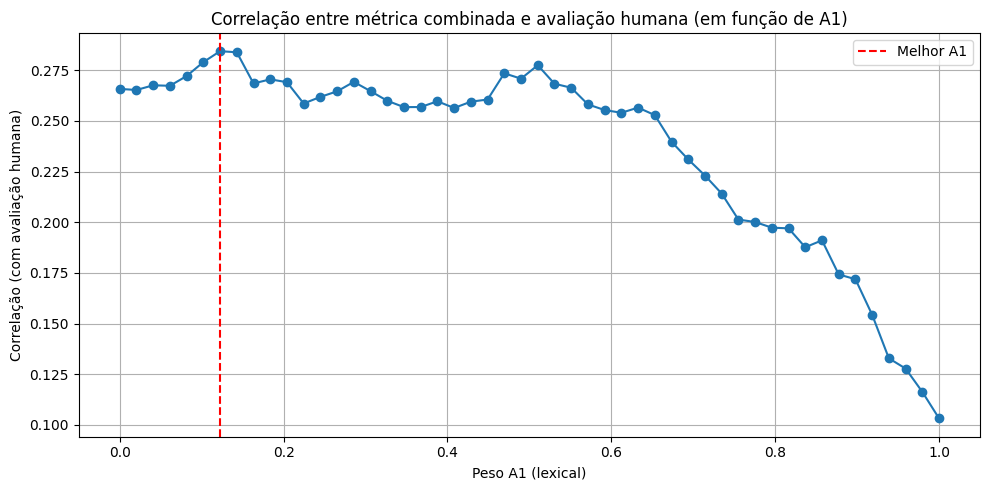

In [28]:
import numpy as np
import matplotlib.pyplot as plt

A1_values = np.linspace(0, 1, 50)  # 50 pontos de 0 a 1
correlations = []

for A1 in A1_values:
    A2 = 1 - A1
    try:
        corr = get_final_corr(avg_summeval_metrics, df_agg, A1, A2)
        correlations.append(corr)
    except:
        correlations.append(np.nan)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(A1_values, correlations, marker='o')
plt.title("Correlação entre métrica combinada e avaliação humana (em função de A1)")
plt.xlabel("Peso A1 (lexical)")
plt.ylabel("Correlação (com avaliação humana)")
plt.grid(True)
plt.axvline(x=A1_values[np.nanargmax(correlations)], color='red', linestyle='--', label='Melhor A1')
plt.legend()
plt.tight_layout()
plt.show()
